# Shape of COVID Outbreaks

In [1]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import matplotlib


import seaborn as sns

import plotly.io as pio
import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from IPython.display import clear_output


import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))
import pipeline

from scipy.stats import ttest_ind


%matplotlib inline

!pwd

/home/barry/projects/covid_projects/the_shape_of_covid


# Load OWID Base Dataset 

In [2]:
df = pd.read_pickle('../generating_covid_datasets/data/base_owid.pkl')
df.shape, df['country'].nunique(), df.date.max()

((40765, 10), 208, Timestamp('2020-09-04 00:00:00'))

# Main Data Pipeline

In [3]:
recency_period = '14d'
def compute_recent_deaths(df, deaths_col='new_deaths_per_100k_rolling', recency_period=recency_period):
    
    recent_deaths_col = 'recent_deaths_{}'.format(recency_period)
    
    # The sum of the new deaths during the infectous period.
    recent_deaths = df.groupby('country')\
        .apply(lambda g: g.set_index('date')[[deaths_col]].rolling(recency_period).sum().clip(lower=.01))\
        .rename(columns={deaths_col: recent_deaths_col})
    
    return df.set_index(['country', 'date']).join(recent_deaths).reset_index()


# fatality_prevalence_lag = 21

# def compute_fatality_ratio(df, deaths_col='new_deaths_per_100k_rolling', prevalence_col='prevalence_14d', prevalence_lag=fatality_prevalence_lag):
    
#     use_col = 'fatality_ratio_{}d'.format(prevalence_lag)
    
#     new_deaths_per_lagged_prevalence = pd.DataFrame(
#         df.groupby('country').apply(lambda g: g.set_index('date')[deaths_col]/g.set_index('date')[prevalence_col].shift(prevalence_lag)),
#         columns=[use_col])
        
#     return df.set_index(['country', 'date']).join(new_deaths_per_lagged_prevalence).reset_index()
    


df = df.pipe(pipeline.compute_per_100k)\
    .pipe(pipeline.compute_totals_per_100k)\
    .pipe(pipeline.compute_rolling)\
    .pipe(pipeline.compute_prevalence)\
    .pipe(compute_recent_deaths)\
    .pipe(lambda df: pipeline.compute_transmission_ratio(df, prevalence_lag=10))\
#     .pipe(compute_fatality_ratio)

df.tail()

,country,date,country_code,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,...,total_tests_smoothed_per_100k,new_cases_per_100k_rolling,new_deaths_per_100k_rolling,new_tests_smoothed_per_100k_rolling,total_cases_per_100k_rolling,total_deaths_per_100k_rolling,total_tests_smoothed_per_100k_rolling,new_cases_per_100k_rolling_prevalence_14d,recent_deaths_14d,new_cases_per_100k_rolling_transmission_ratio_10d
40760,Zimbabwe,2020-08-31,ZWE,ZW,Africa,east_africa,6.0,0.0,1072.0,14862927.0,...,589.237907,0.463281,0.039408,7.561479,42.305645,1.226446,567.332974,8.705265,0.411378,0.049164
40761,Zimbabwe,2020-09-01,ZWE,ZW,Africa,east_africa,85.0,6.0,992.0,14862927.0,...,595.912232,0.410417,0.045175,7.295237,42.716062,1.271620,574.628210,8.577430,0.426757,0.046087
40762,Zimbabwe,2020-09-02,ZWE,ZW,Africa,east_africa,62.0,1.0,NaN,14862927.0,...,NaN,0.348903,0.035563,7.206970,43.064965,1.307183,578.287843,8.388081,0.426757,0.040040
40763,Zimbabwe,2020-09-03,ZWE,ZW,Africa,east_africa,79.0,3.0,NaN,14862927.0,...,NaN,0.371971,0.025951,7.142604,43.436935,1.333135,581.905569,8.039178,0.425796,0.042967
40764,Zimbabwe,2020-09-04,ZWE,ZW,Africa,east_africa,40.0,0.0,NaN,14862927.0,...,NaN,0.371009,0.016340,7.108290,43.807945,1.349475,585.512194,7.684508,0.420029,0.042436


# Visualising COVID-19 Outbreaks

In [4]:

def plot_covid_trace(ax, df, size_scale=35, trace_width=.5):

    prevalence_col = 'new_cases_per_100k_rolling_prevalence_14d'
    transmission_ratio_col = 'new_cases_per_100k_rolling_transmission_ratio_10d'
    deaths_col = 'recent_deaths_14d'

    every_n = 1
    
    colour_scale = .85

    cmap = matplotlib.cm.get_cmap('YlOrRd')
    
    tr = df[[prevalence_col, transmission_ratio_col, deaths_col]].dropna().rolling('7d').mean()

    tr = tr.dropna().copy()

    # Clip the outliers
    tr[prevalence_col] = tr[prevalence_col].clip(lower=.1)
    tr[transmission_ratio_col] = tr[transmission_ratio_col].clip(lower=.01, upper=1)

    # Need rel deaths for colour selction
    tr['rel_deaths'] = tr[deaths_col]/tr[deaths_col].max()

    # Mark the death rates
    for i, (_, row) in enumerate(tr.iterrows()):

        # Mark every n'th point with a death rate marker
        if  (i%every_n==0) & (not(np.isnan(row[deaths_col]))):

            s = row[deaths_col]*size_scale  # The size based on current per capita deaths
            c = cmap((1-colour_scale)+row['rel_deaths']*colour_scale)     # Colour based on relative deaths.

            ax.scatter(row[prevalence_col], row[transmission_ratio_col], s=[s], alpha=.6, color=c, marker='s')

    # Plot the trace
    ax.plot(tr[prevalence_col], tr[transmission_ratio_col], lw=trace_width, c='k')

    # Mark the end point so that we can tell which end is which.
    ax.plot([tr.iloc[-1][prevalence_col]], [tr.iloc[-1][transmission_ratio_col]], marker='o', markeredgecolor='k', markersize=6, c='w')
    
    # Log scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(0.004, 1.1)
    ax.set_yticklabels([])
    ax.set_xlim(.08, 1200)

        
def plot_covid_traces(df, nrows, ncols, h=4, w=4, size_scale=25, trace_width=1, show_annotations=True, *arge, **kwargs):
    
    from_date = datetime(2020, 3, 17)
    
    prevalence_col = 'new_cases_per_100k_rolling_prevalence_14d'

    fig, axes = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, sharex=True, sharey=False, **kwargs)
    axs = axes.flatten()

    countries = df['country'].unique()
    
    # Plot each countries trace as a separate graph.
    for i, country in enumerate(countries):
        clear_output(wait=True)
        print(country)

        # The main trace
        data = df[df['country']==country].sort_values(by='date', ascending=True).set_index('date').loc[from_date:]
        plot_covid_trace(axs[i], data, size_scale=size_scale, trace_width=trace_width)
        
        # The quadrant partitions wrt countries of interest
        axs[i].axvline(df[prevalence_col].median(), c='grey', lw=.5, ls='--')
        axs[i].axhline(1/14, c='grey', lw=.5, ls='--')
    
        
        # Axes and labels

        # The title
        axs[i].set_title('{} (pop. {:,}M)'.format(country.upper(), round(df[df['country']==country]['population'].max()/1000000, 1)))
        
        # Add x axis labels to the bottom graphs.
        if i>=(len(countries)-ncols): 
            axs[i].set_xlabel('Prevalence (per 100k)')
            axs[i].set_xticks([.1, 1, 10, 100, 1000])
            axs[i].set_xticklabels(['0.1', '1', '10', '100', '1,000'])
            
        # Add y axis labels to left hand graphs
        if i%ncols==0: 
            axs[i].set_ylabel('Transmission Ratio (7d)')
            axs[i].set_yticks([.01, .1, 1])
            axs[i].set_yticklabels(['1%', '10%', '100%'])
            
        if show_annotations:
            axs[i].annotate('{} total / {} max daily c/100k\n{} total / {} max 14d d/100k'.format(
                round(df[df['country']==country]['total_cases_per_100k'].max(), 1),
                round(df[df['country']==country]['new_cases_per_100k_rolling'].max(), 1),
                round(df[df['country']==country]['total_deaths_per_100k'].max(), 1),
                round(df[df['country']==country]['recent_deaths_14d'].max(), 1)
            ), xy=(.5, .0025), xycoords='axes fraction', ha='center', va='bottom')
            
            
        
    return fig, axes

## An Example Visualisation

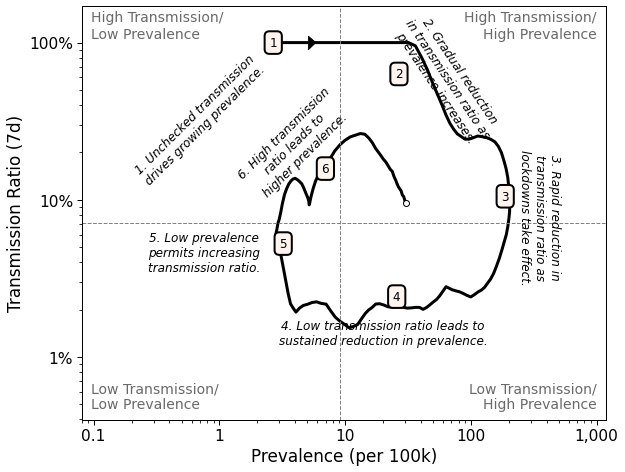

In [5]:
sns.set_context('paper', font_scale=1.75)

fig, ax = plt.subplots(figsize=(9, 7))



prevalence_col = 'new_cases_per_100k_rolling_prevalence_14d'
transmission_ratio_col = 'new_cases_per_100k_rolling_transmission_ratio_10d'
deaths_col = 'recent_deaths_14d'

from_date = datetime(2020, 3, 17)

country = 'Ireland'
data = df[df['country']==country].set_index('date').loc[from_date:]


plot_covid_trace(ax, data, size_scale=0, trace_width=3)


recent_deaths = df[df['country']==country][deaths_col]
norm = matplotlib.colors.Normalize(vmin=recent_deaths.min(), vmax=recent_deaths.max())
cmap = matplotlib.cm.get_cmap('YlOrRd')

# cax = fig.add_axes([1, .2, 0.025, .7])
# cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
# cb.set_label('Recent (14d) Deaths/100k')

ax.axvline(9.12, c='grey', lw=1, ls='--', color='grey')
ax.axhline(1/14, c='grey', lw=1, ls='--', color='grey')

p = data[prevalence_col].rolling('7d').mean().clip(lower=.1)
tr = data[transmission_ratio_col].rolling('7d').mean().clip(lower=.01, upper=1)

    
ax.text(.095, .0045, 'Low Transmission/\nLow Prevalence', color='dimgrey', va='bottom', fontsize=14)
ax.text(.095, 1.6, 'High Transmission/\nLow Prevalence', color='dimgrey', va='top', fontsize=14)

ax.text(1000, .0045, 'Low Transmission/\nHigh Prevalence', color='dimgrey', va='bottom', ha='right', fontsize=14)
ax.text(1000, 1.6, 'High Transmission/\nHigh Prevalence', color='dimgrey', va='top', ha='right', fontsize=14)


ax.set_xlim(.08, 1200)
ax.set_xlabel('Prevalence (per 100k)')
ax.set_xticks([.1, 1, 10, 100, 1000])
ax.set_xticklabels(['0.1', '1', '10', '100', '1,000'])

ax.set_ylim(0.004, 1.7)
ax.set_ylabel('Transmission Ratio (7d)')
ax.set_yticks([.01, .1, 1])
ax.set_yticklabels(['1%', '10%', '100%'])


fontsize = 12

ax.annotate('1. Unchecked transmission\ndrives growing prevalence.', xy=(.7, .125), rotation=45, fontsize=fontsize, ha='center', style='oblique')
ax.annotate('2. Gradual reduction\nin transmission ratio as\nprevalence increases.', xy=(65, .22), rotation=-56, fontsize=fontsize, ha='center', style='oblique')
ax.annotate('3. Rapid reduction in\ntransmission ratio as\nlockdowns take effect.', xy=(350, .03), rotation=-90, fontsize=fontsize, ha='center', style='oblique')
ax.annotate('4. Low transmission ratio leads to\nsustained reduction in prevalence.', xy=(20, .012), rotation=0, fontsize=fontsize, ha='center', style='oblique')
ax.annotate('5. Low prevalence\npermits increasing\ntransmission ratio.', xy=(.75, .035), rotation=0, fontsize=fontsize, ha='center', style='oblique')
ax.annotate('6. High transmission\nratio leads to\nhigher prevalence.', xy=(4, .1), rotation=45, fontsize=fontsize, ha='center', style='oblique')

ax.text(2.5, .95, '1', fontsize=fontsize, bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2))
ax.text(25, .6, '2', fontsize=fontsize, bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2))
ax.text(175, .1, '3', fontsize=fontsize, bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2))
ax.text(24, .023, '4', fontsize=fontsize, bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2))
ax.text(3, .05, '5', fontsize=fontsize, bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2))
ax.text(6.5, .15, '6', fontsize=fontsize, bbox=dict(facecolor='seashell', edgecolor='black', boxstyle='round,pad=.4', lw=2))

ax.arrow(5,1,.1,0, width=0, color="k", head_width=0.2, head_length=0.75)



fig.tight_layout()

fig.savefig('graphs/example_spiral_ireland.png', format='png')

This chart shows the trace for Ireland and it provides a good example of one of the common ways that outbreaks tend to evolve in countries where lockdowns have been introduced. It is useful to explain this in terms of a number of distinct phases as follows:
1. Early on in an outbreak, when transmission is out of control prevalence increases rapidly.
2. As prevalence peaks the transmission ratio will tend to fall, especially as mitigations such as loickdowns are introduced.
3. If and when lockdowns take effect, then transmission ration increases will be arrested and prevalence will stabilise.
4. In due course reducing transmisison will lead to reducing prevalence.
5. If transmission can be reduced over a sustained period then prevalence will fall to very low levels, but new outbreaks will then have an out-sized impact on the transmission ratio.
6. And increased transmission leads to increasing prevalence as a new cycle begins.

## Ireland & Germany

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


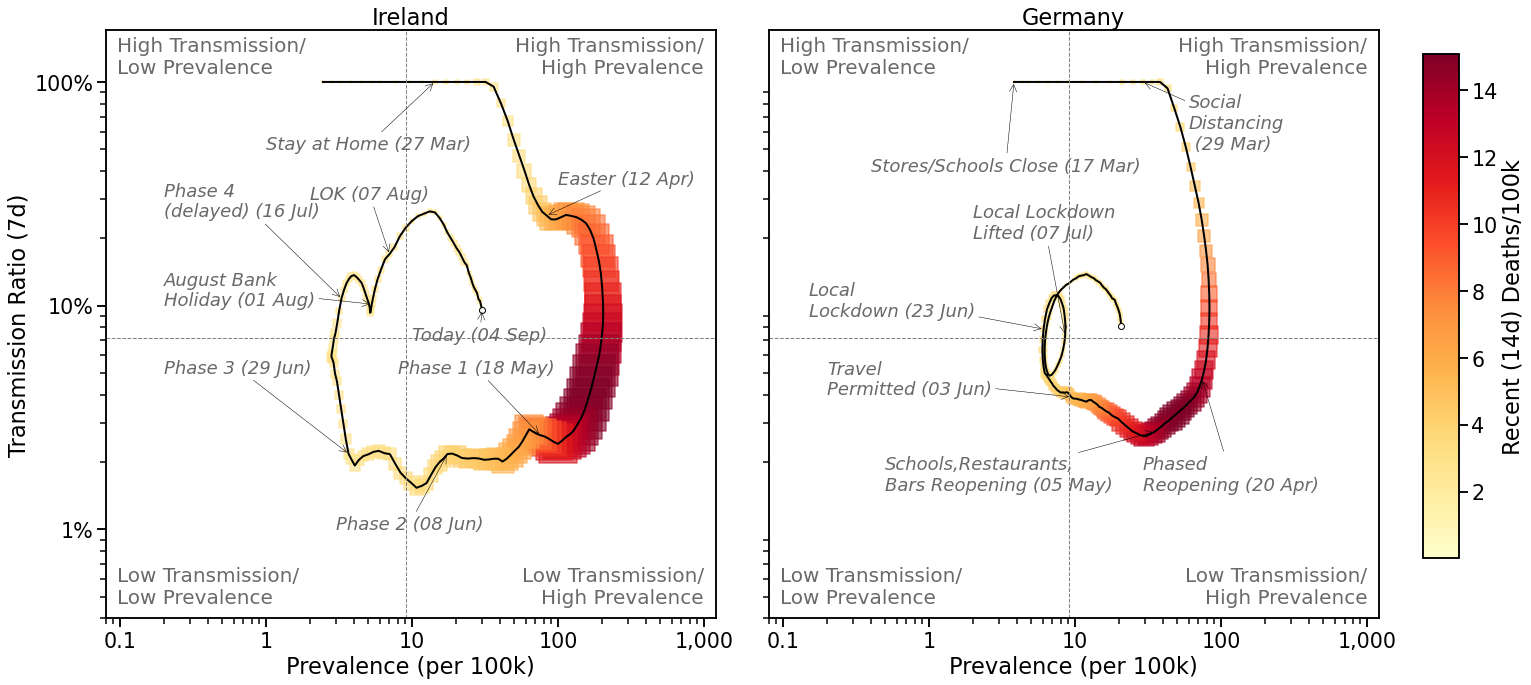

In [6]:
sns.set_context('talk', font_scale=1.25)

fig, (ax, bx) = plt.subplots(figsize=(20, 10), ncols=2, sharex=True, sharey=False)

from_date = datetime(2020, 3, 17)

country = 'Ireland'
data = df[df['country']==country].set_index('date').loc[from_date:]


plot_covid_trace(ax, data, size_scale=125, trace_width=2)


recent_deaths = df[df['country']==country][deaths_col]
norm = matplotlib.colors.Normalize(vmin=recent_deaths.min(), vmax=recent_deaths.max())
cmap = matplotlib.cm.get_cmap('YlOrRd')

cax = fig.add_axes([1, .2, 0.025, .7])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('Recent (14d) Deaths/100k')

ax.axvline(9.12, c='grey', lw=1, ls='--', color='grey')
ax.axhline(1/14, c='grey', lw=1, ls='--', color='grey')

p = data[prevalence_col].rolling('7d').mean().clip(lower=.1)
tr = data[transmission_ratio_col].rolling('7d').mean().clip(lower=.01, upper=1)

    
ax.text(.095, .0045, 'Low Transmission/\nLow Prevalence', color='dimgrey', va='bottom', fontsize=20)
ax.text(.095, 1.6, 'High Transmission/\nLow Prevalence', color='dimgrey', va='top', fontsize=20)

ax.text(1000, .0045, 'Low Transmission/\nHigh Prevalence', color='dimgrey', va='bottom', ha='right', fontsize=20)
ax.text(1000, 1.6, 'High Transmission/\nHigh Prevalence', color='dimgrey', va='top', ha='right', fontsize=20)



# lockdown_start
key_events = [
    ('Stay at Home', datetime(2020, 3, 27), (1, .5)),
    ('Easter', datetime(2020, 4, 12), (100, .35)),
    ('Phase 1', datetime(2020, 5, 18), (8, .05)),
    ('Phase 2', datetime(2020, 6, 8), (3, .01)),
    ('Phase 3', datetime(2020, 6, 29), (.2, .05)),
    ('Phase 4\n(delayed)', datetime(2020, 7, 16), (.2, .25)),
    ('August Bank\nHoliday', datetime(2020, 8, 1), (.2, .1)),
    ('Today', data.index.max(), (10, .07)),
    ('LOK', datetime(2020, 8, 7), (2, .3))
]

for label, date, (x_adj, y_adj) in key_events:
    x = p.loc[date]
    y = tr.loc[date]
    
    ax.annotate(
        label+' ({})'.format(date.strftime('%d %b')), 
        xy=(x,y), xytext=(x_adj, y_adj), 
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=.5), 
        fontsize=18, color='dimgrey', style='oblique'
    )
    
    

ax.set_title(country)


    
# Germany
country = 'Germany'
data = df[df['country']==country].set_index('date').loc[from_date:]


plot_covid_trace(bx, data, size_scale=125, trace_width=2)


recent_deaths = df[df['country']==country][deaths_col]
norm = matplotlib.colors.Normalize(vmin=recent_deaths.min(), vmax=recent_deaths.max())
cmap = matplotlib.cm.get_cmap('YlOrRd')

bx.set_title(country)

bx.set_xlabel('Prevalence (per 100k)')


bx.axvline(9.12, c='grey', lw=1, ls='--', color='grey')
bx.axhline(1/14, c='grey', lw=1, ls='--', color='grey')


p = data[prevalence_col].rolling('7d').mean().clip(lower=.1)
tr = data[transmission_ratio_col].rolling('7d').mean().clip(lower=.01, upper=1)
    

bx.text(.095, .0045, 'Low Transmission/\nLow Prevalence', color='dimgrey', va='bottom', fontsize=20)
bx.text(.095, 1.6, 'High Transmission/\nLow Prevalence', color='dimgrey', va='top', fontsize=20)

bx.text(1000, .0045, 'Low Transmission/\nHigh Prevalence', color='dimgrey', va='bottom', ha='right', fontsize=20)
bx.text(1000, 1.6, 'High Transmission/\nHigh Prevalence', color='dimgrey', va='top', ha='right', fontsize=20)



# lockdown_start
key_events = [
    ('Stores/Schools Close', datetime(2020, 3, 17), (.4, .4)),
    ('Social\nDistancing\n', datetime(2020, 3, 29), (60, .5)),
    ('Phased\nReopening', datetime(2020, 4, 20), (29, .015)),
    ('Schools,Restaurants,\nBars Reopening', datetime(2020, 5, 5), (.5, .015)),
    ('Travel\nPermitted', datetime(2020, 6, 3), (.2, .04)),
    ('Local\nLockdown', datetime(2020, 6, 23), (.15, .09)),
    ('Local Lockdown\nLifted', datetime(2020, 7, 7), (2, .2)),
]

for label, date, (x_adj, y_adj) in key_events:
    x = p.loc[date]
    y = tr.loc[date]
    
    bx.annotate(
        label+' ({})'.format(date.strftime('%d %b')), 
        xy=(x,y), xytext=(x_adj, y_adj), 
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=.5), 
        fontsize=18, color='dimgrey', style='oblique'
    )

    
ax.set_xlim(.08, 1200)
ax.set_xlabel('Prevalence (per 100k)')
ax.set_xticks([.1, 1, 10, 100, 1000])
ax.set_xticklabels(['0.1', '1', '10', '100', '1,000'])

ax.set_ylim(0.004, 1.7)
ax.set_ylabel('Transmission Ratio (7d)')
ax.set_yticks([.01, .1, 1])
ax.set_yticklabels(['1%', '10%', '100%'])

bx.set_xlabel('Prevalence (per 100k)')
bx.set_xticks([.1, 1, 10, 100, 1000])
bx.set_xticklabels(['0.1', '1', '10', '100', '1,000'])

bx.set_ylim(0.004, 1.7)
bx.set_ylabel('')
bx.set_yticks([])


fig.tight_layout()

fig.savefig('graphs/ireland_germany_covid_spiral.png', format='png', bbox_inches='tight')

Here were see the trajectory traced by Ireland and Germany through the pandemic, each annotated with key landmarks durign its respective lockdown and subsequent easing of restrictions. These graphs also indicate the total per capita deaths in each country over a two week period; the thickness and colour of the shading is proprtional to the number of recent deaths per 100,000 of population. 

In both cases the impact of lcokdown is clear, leading to a sustained decrease in the transmission ratio and a similarly sustained reduction in prevalence. The impact of a subsequent targetted lockdown in Germany in late June is also visible. Ireland suffered a larger per capita death rate than Germany and most of these deaths occured during April and May as transmission rates were falling, but while prevalence remained high, an indication of continuing pressure on Ireland's healthcare system. The vast majority of COVID-attributed deaths in Germany also occurred in April and May, but against a backdrop of lower prevalence.

The key point to be made here is that that this novel and information rich approach to visualising a COVID outbreak helps to highlight key features of an outbreak, such as prevalence, transmission, and fatality rates, and how they evolve over time as conditions and policies vary. Moreover, comparing the traces of different countries reveals a number of canonical patterns that are associated with different types of response and different levels of efficacy. In the traces of Ireland and Germany we see a common pattern displayed by many other countries, in the contours of an evolving spiral sometimes punctuated by smaller loops, as in the case of Germany. The main spiral reveals the contours of the primary lockdown, typically tracing out a period of at least months as significant restrictions are imposed and then gradually relaxed, and the changes in prevalence and transmission that accompany these phases. With a sustained successful lockdown, such as those in Ireland and Germany, high prevalence and transmission are brought under control

## Brazil & United States

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


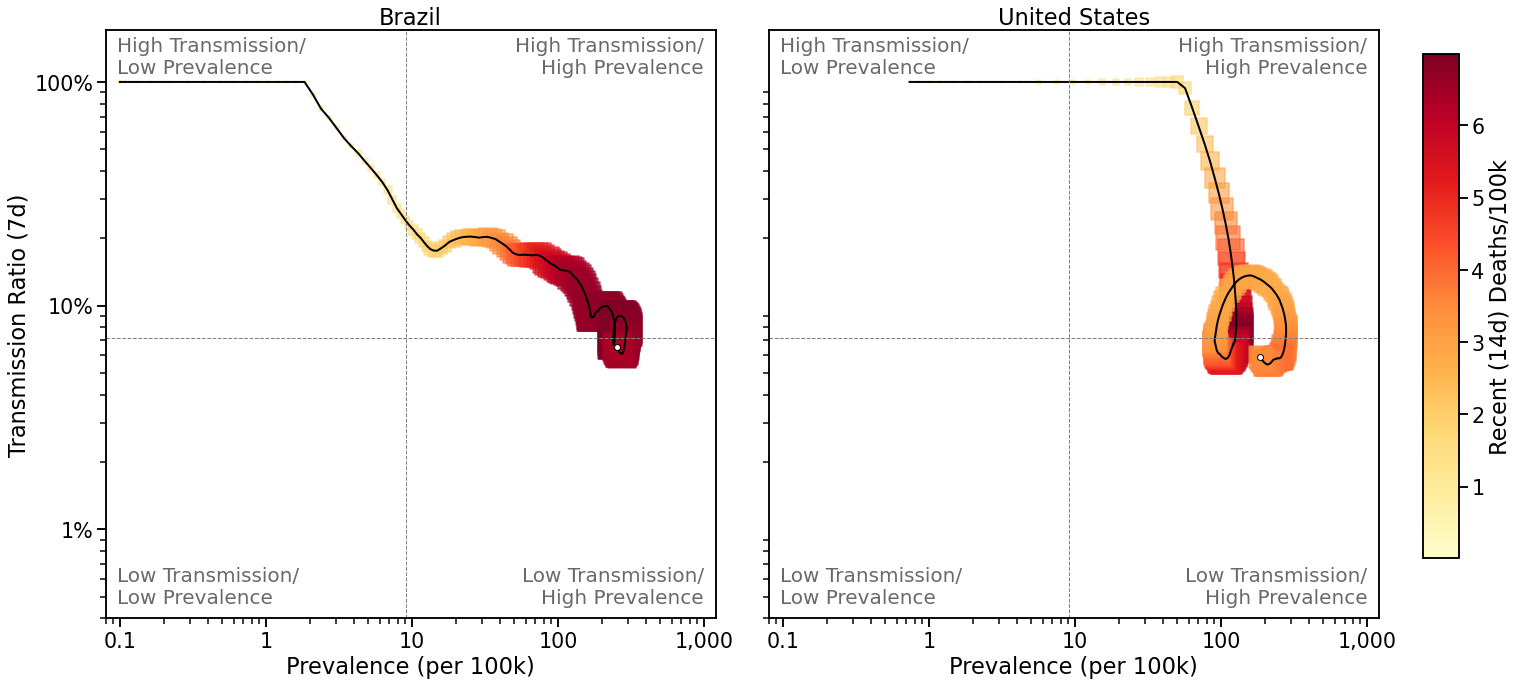

In [7]:
sns.set_context('talk', font_scale=1.25)

fig, (ax, bx) = plt.subplots(figsize=(20, 10), ncols=2, sharex = True, sharey=False)

from_date = datetime(2020, 3, 17)

country = 'Brazil'
data = df[df['country']==country].set_index('date').loc[from_date:]


plot_covid_trace(ax, data, size_scale=125, trace_width=2)


recent_deaths = df[df['country']==country][deaths_col]
norm = matplotlib.colors.Normalize(vmin=recent_deaths.min(), vmax=recent_deaths.max())
cmap = matplotlib.cm.get_cmap('YlOrRd')

cax = fig.add_axes([1, .2, 0.025, .7])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('Recent (14d) Deaths/100k')

ax.set_title(country)


ax.axvline(9.12, c='grey', lw=1, ls='--', color='grey')
ax.axhline(1/14, c='grey', lw=1, ls='--', color='grey')


p = data[prevalence_col].rolling('7d').mean().clip(lower=.1)
tr = data[transmission_ratio_col].rolling('7d').mean().clip(lower=.01, upper=1)

    
ax.text(.095, .0045, 'Low Transmission/\nLow Prevalence', color='dimgrey', va='bottom', fontsize=20)
ax.text(.095, 1.6, 'High Transmission/\nLow Prevalence', color='dimgrey', va='top', fontsize=20)

ax.text(1000, .0045, 'Low Transmission/\nHigh Prevalence', color='dimgrey', va='bottom', ha='right', fontsize=20)
ax.text(1000, 1.6, 'High Transmission/\nHigh Prevalence', color='dimgrey', va='top', ha='right', fontsize=20)



    
# US
country = 'United States'
data = df[df['country']==country].set_index('date').loc[from_date:]


plot_covid_trace(bx, data, size_scale=125, trace_width=2)


recent_deaths = df[df['country']==country][deaths_col]
norm = matplotlib.colors.Normalize(vmin=recent_deaths.min(), vmax=recent_deaths.max())
cmap = matplotlib.cm.get_cmap('YlOrRd')

bx.set_title(country)

bx.set_xlabel('Prevalence (per 100k)')


bx.axvline(9.12, c='grey', lw=1, ls='--', color='grey')
bx.axhline(1/14, c='grey', lw=1, ls='--', color='grey')


p = data[prevalence_col].rolling('7d').mean().clip(lower=.1)
tr = data[transmission_ratio_col].rolling('7d').mean().clip(lower=.01, upper=1)
    
bx.text(.095, .0045, 'Low Transmission/\nLow Prevalence', color='dimgrey', va='bottom', fontsize=20)
bx.text(.095, 1.6, 'High Transmission/\nLow Prevalence', color='dimgrey', va='top', fontsize=20)

bx.text(1000, .0045, 'Low Transmission/\nHigh Prevalence', color='dimgrey', va='bottom', ha='right', fontsize=20)
bx.text(1000, 1.6, 'High Transmission/\nHigh Prevalence', color='dimgrey', va='top', ha='right', fontsize=20)

   
ax.set_xlim(.08, 1200)
ax.set_xlabel('Prevalence (per 100k)')
ax.set_xticks([.1, 1, 10, 100, 1000])
ax.set_xticklabels(['0.1', '1', '10', '100', '1,000'])

ax.set_ylim(0.004, 1.7)
ax.set_ylabel('Transmission Ratio (7d)')
ax.set_yticks([.01, .1, 1])
ax.set_yticklabels(['1%', '10%', '100%'])

bx.set_xlabel('Prevalence (per 100k)')
bx.set_xticks([.1, 1, 10, 100, 1000])
bx.set_xticklabels(['0.1', '1', '10', '100', '1,000'])

bx.set_ylim(0.004, 1.7)
bx.set_ylabel('')
bx.set_yticks([])

    
fig.tight_layout()

fig.savefig('graphs/brazil_us_covid_spiral.png'.format(country), format='png', bbox_inches='tight')

# Outbreak Types

## Assigning Outbreak Types
Currently this is done by visual inspection. COuntries that have a clear large spiral are assigned to be S, all others are assigned to be D.

In [8]:
50*.005

0.25

In [9]:
min_cases_per_100k = 50
total_cases_per_100k = df.groupby('country').last()['total_cases_per_100k_rolling']
countries_with_min_cases = set(total_cases_per_100k[total_cases_per_100k>min_cases_per_100k].index)

min_deaths_per_100k = min_cases_per_100k*.005
total_deaths_per_100k = df.groupby('country').last()['total_deaths_per_100k_rolling']
countries_with_min_deaths = set(total_deaths_per_100k[total_deaths_per_100k>min_deaths_per_100k].index)

min_pop = 1000000
populations = df.groupby('country').last()['population']
countries_with_min_pop = set(populations[populations>min_pop].index)

all_countries = countries_with_min_cases.intersection(countries_with_min_deaths).intersection(countries_with_min_pop)

len(all_countries)

110

In [10]:
d_type_countries = {
    'India',
    'United States',
    'Brazil',
    'Bangladesh',
    'Russia', 
    'Mexico',
    'Philippines',
    'Colombia',
    'Argentina',
    'Ukraine', 
    'Iraq', 
    'Iran',
    'Peru',
    'Venezuela',
#     'Chile',                 # Transitioning to S
#     'Kazakhstan',
    'Guatemala',
    'Bolivia',
#     'Dominican Republic',
    'Honduras',
#     'El Salvador',
#     'Libya',                 # Very early evidence of S but at tiny prevalence
    'Panama',
    'Kuwait',
    'Moldova',
    'Bahrain', 
    'Indonesia',
    'Senegal',
#     'Nicaragua',
#     'Albania',
#     'Costa Rica',
#     'Namibia',
#     'Gambia',
    'Swaziland',
#     'Lebanon',              # Early spiral but nothing since.
#     'Palestine', 
#     'Paraguay',
    'Poland',
    'Chile',    
    
    
}

s_type_countries = all_countries.difference(d_type_countries)

len(d_type_countries), len(s_type_countries)

(26, 84)

In [11]:
s_type_countries = all_countries.difference(d_type_countries)

len(s_type_countries)

84

## Select Countries to Analyse by Outbreak Type

In [12]:
countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia',
    'Czech Republic', 'Denmark', 'Finland', 'France',
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy',
    'Luxembourg', 'Netherlands', 'Poland',
    'Portugal', 'Romania', 'Spain', 'Sweden', 
    'United Kingdom', 'Iceland', 'Norway', 'Switzerland', 'Canada', 
    
    'Israel', 'Japan', 'South Korea', 'Australia', 'South Africa',
    'United States', 'Brazil', 'Peru', 'Chile', 'Mexico', 'Argentina'
]

main_countries = df[df['country'].isin(countries)].country.unique()
len(main_countries), len(countries)

(36, 36)

In [13]:
use_countries = all_countries  #

data = df[df['country'].isin(use_countries)].sort_values(by=['population'], ascending=False).copy()


data['outbreak_type'] = np.where(data['country'].isin(d_type_countries), 'D', 'S')

data.groupby('country')['outbreak_type'].last().value_counts()

S    84
D    26
Name: outbreak_type, dtype: int64

## Outbreak Type by Continent

In [14]:
data.groupby(['continent', 'country']).last().groupby('continent')['outbreak_type'].value_counts().unstack(), data.groupby(['continent', 'country']).last().groupby('continent')['outbreak_type'].value_counts().unstack().sum()

(outbreak_type    D     S
 continent               
 Africa         2.0  21.0
 Asia           8.0  20.0
 Europe         4.0  31.0
 North America  5.0   9.0
 Oceania        NaN   1.0
 South America  7.0   2.0,
 outbreak_type
 D    26.0
 S    84.0
 dtype: float64)

## Cases/Deaths by Outbreak Type

In [15]:
total_cases_per_100k_by_outbreak_types = data.groupby(['outbreak_type', 'country'])['new_cases_per_100k'].sum()
total_deaths_per_100k_by_outbreak_types = data.groupby(['outbreak_type', 'country'])['new_deaths_per_100k'].sum()
cfr_by_outbreak_type = total_deaths_per_100k_by_outbreak_types/total_cases_per_100k_by_outbreak_types

[
    total_cases_per_100k_by_outbreak_types.groupby('outbreak_type').agg(['mean', 'std']),
    total_deaths_per_100k_by_outbreak_types.groupby('outbreak_type').agg(['mean', 'std']),
    cfr_by_outbreak_type.groupby('outbreak_type').agg(['mean', 'std']),
]

[                     mean         std
 outbreak_type                        
 D              950.457234  847.180397
 S              433.800217  548.709002,
                     mean        std
 outbreak_type                      
 D              24.844674  23.621999
 S              11.909509  16.764688,
                    mean       std
 outbreak_type                    
 D              0.029112  0.020298
 S              0.029223  0.026821]

In [16]:
total_cases_per_100k_by_outbreak_types.groupby('outbreak_type').mean().pct_change()

outbreak_type
D         NaN
S   -0.543588
Name: new_cases_per_100k, dtype: float64

In [17]:
total_deaths_per_100k_by_outbreak_types.groupby('outbreak_type').mean().pct_change()

outbreak_type
D         NaN
S   -0.520641
Name: new_deaths_per_100k, dtype: float64

In [18]:
[
    ttest_ind(total_cases_per_100k_by_outbreak_types.loc['S'], total_cases_per_100k_by_outbreak_types.loc['D']),
    ttest_ind(total_deaths_per_100k_by_outbreak_types.loc['S'], total_deaths_per_100k_by_outbreak_types.loc['D']),
    ttest_ind(cfr_by_outbreak_type.loc['S'], cfr_by_outbreak_type.loc['D']),
]

[Ttest_indResult(statistic=-3.6513243006749936, pvalue=0.0004039612368270623),
 Ttest_indResult(statistic=-3.1023469850525873, pvalue=0.00245033540970427),
 Ttest_indResult(statistic=0.019454728172070567, pvalue=0.9845142486043632)]

## Current Prevalence & Recent Deaths

In [19]:
current_prevalence_by_outbreak_types = data.groupby(['outbreak_type', 'country'])['new_cases_per_100k_rolling_prevalence_14d'].mean()
current_recent_deaths_by_outbreak_types = data.groupby(['outbreak_type', 'country'])['recent_deaths_14d'].mean()
current_cfr_by_outbreak_type = current_recent_deaths_by_outbreak_types/current_prevalence_by_outbreak_types

[
    current_prevalence_by_outbreak_types.groupby('outbreak_type').agg(['mean', 'std']),
    current_recent_deaths_by_outbreak_types.groupby('outbreak_type').agg(['mean', 'std']),
    current_cfr_by_outbreak_type.groupby('outbreak_type').agg(['mean', 'std']),

    ttest_ind(current_prevalence_by_outbreak_types.loc['S'], current_prevalence_by_outbreak_types.loc['D']),
    ttest_ind(current_recent_deaths_by_outbreak_types.loc['S'], current_recent_deaths_by_outbreak_types.loc['D']),
    ttest_ind(current_cfr_by_outbreak_type.loc['S'], current_cfr_by_outbreak_type.loc['D']),

]

[                    mean        std
 outbreak_type                      
 D              58.477702  52.136053
 S              25.932320  31.289844,
                    mean       std
 outbreak_type                    
 D              1.582948  1.598108
 S              0.714017  0.949848,
                    mean       std
 outbreak_type                    
 D              0.029562  0.020426
 S              0.030735  0.029347,
 Ttest_indResult(statistic=-3.9014311286583085, pvalue=0.00016659470501548382),
 Ttest_indResult(statistic=-3.4161611695031864, pvalue=0.0008960455790223064),
 Ttest_indResult(statistic=0.18977574967416252, pvalue=0.8498410815413295)]

## Peak Prevalence & Deaths

In [20]:
peak_prevalence_by_outbreak_types = data.groupby(['outbreak_type', 'country'])['new_cases_per_100k_rolling_prevalence_14d'].max()
peak_recent_deaths_by_outbreak_types = data.groupby(['outbreak_type', 'country'])['recent_deaths_14d'].max()


[
    peak_prevalence_by_outbreak_types.groupby('outbreak_type').agg(['mean', 'std']),
    peak_recent_deaths_by_outbreak_types.groupby('outbreak_type').agg(['mean', 'std']),
    ttest_ind(peak_prevalence_by_outbreak_types.loc['S'], peak_prevalence_by_outbreak_types.loc['D']),
    ttest_ind(peak_recent_deaths_by_outbreak_types.loc['S'], peak_recent_deaths_by_outbreak_types.loc['D']),
]

[                     mean         std
 outbreak_type                        
 D              170.882258  147.980058
 S              101.589233  118.649655,
                    mean       std
 outbreak_type                    
 D              4.680857  4.740658
 S              3.605289  5.804949,
 Ttest_indResult(statistic=-2.4495413236949397, pvalue=0.015911306917082545),
 Ttest_indResult(statistic=-0.8593935931689778, pvalue=0.392026942249761)]

## Visualising Outbreaks

Swaziland


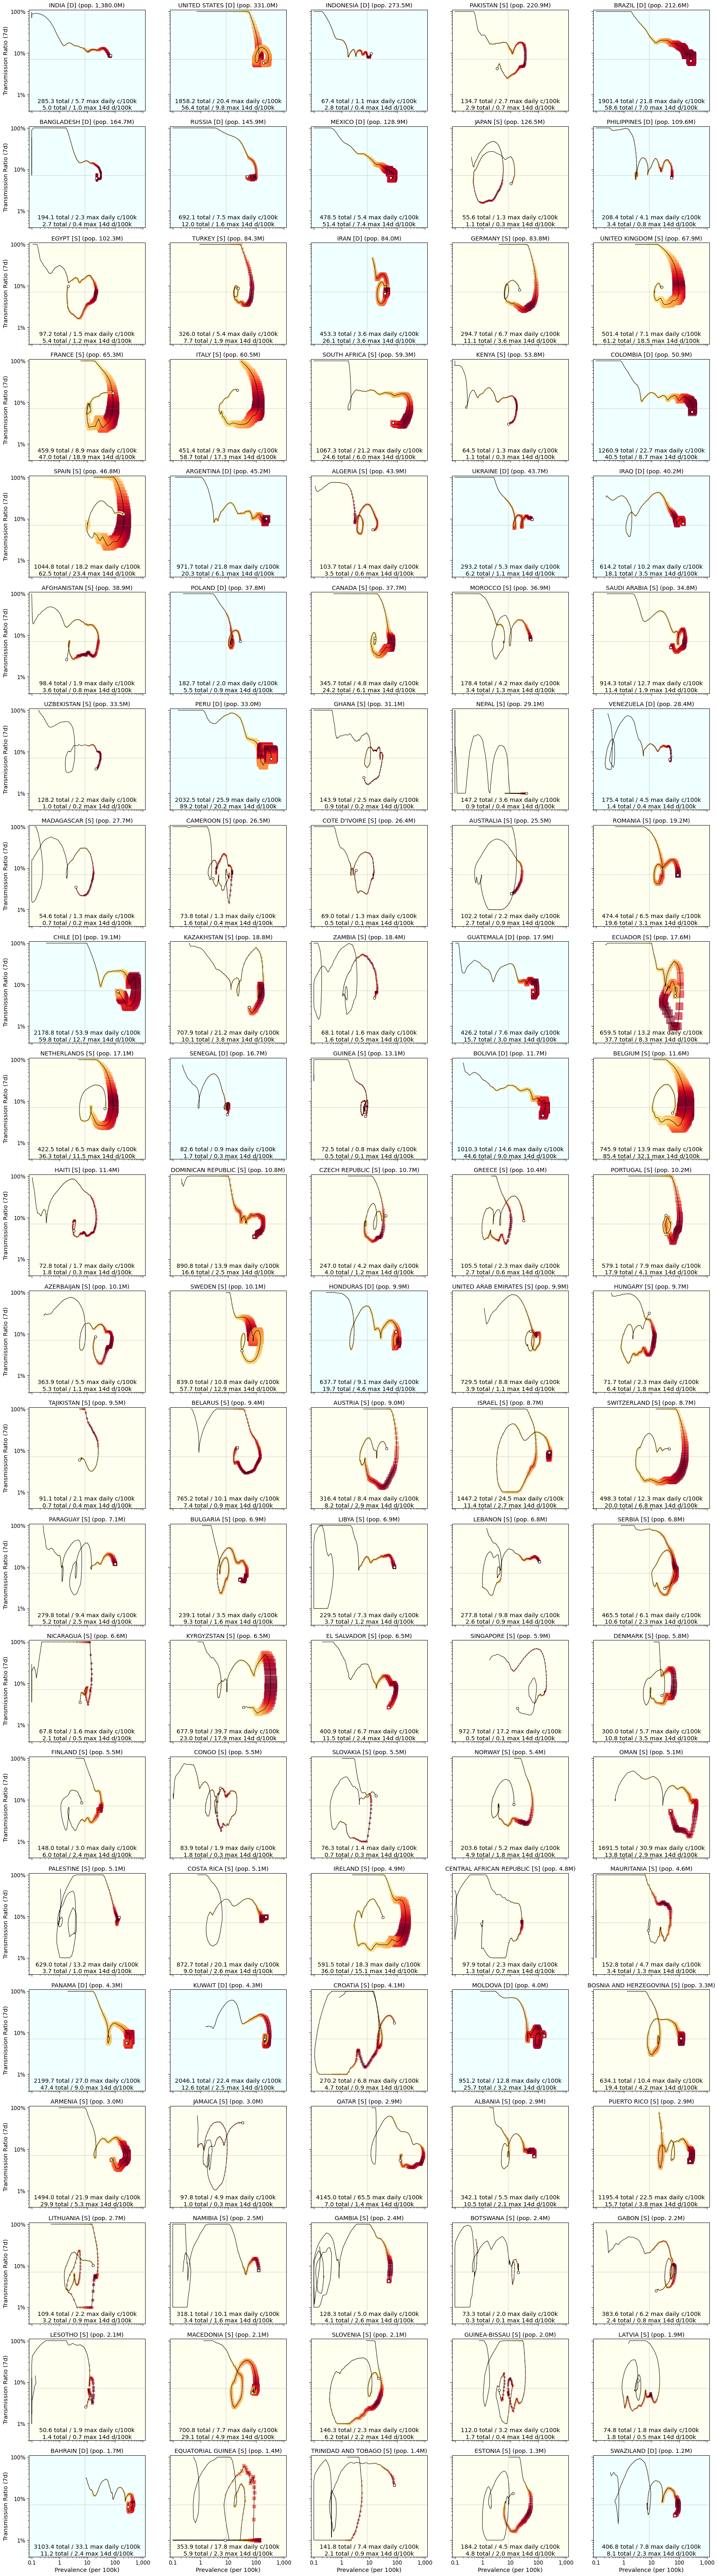

In [21]:
sns.set_context('paper', font_scale=1.5)

ncols = 5

h, w = 4, 5


fig, axes = plot_covid_traces(data, nrows=((data.country.nunique()-1)//ncols)+1, ncols=ncols, h=h, w=w, size_scale=50)

# Add outbreak types and colouring
for country, ax in zip(data['country'].unique(), axes.flatten()):
    ax.set_title(ax.get_title().replace('(', '[{}] (').format(
        data.set_index('country').loc[country].iloc[0]['outbreak_type']))
    if data.set_index('country').loc[country].iloc[0]['outbreak_type']=='S':
        ax.set_facecolor('ivory')
    else:
        ax.set_facecolor('azure')




plt.tight_layout()

fig.savefig('./graphs/all_countries_by_population_covid_traces.png', format='png', dpi=300)





Swaziland


/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


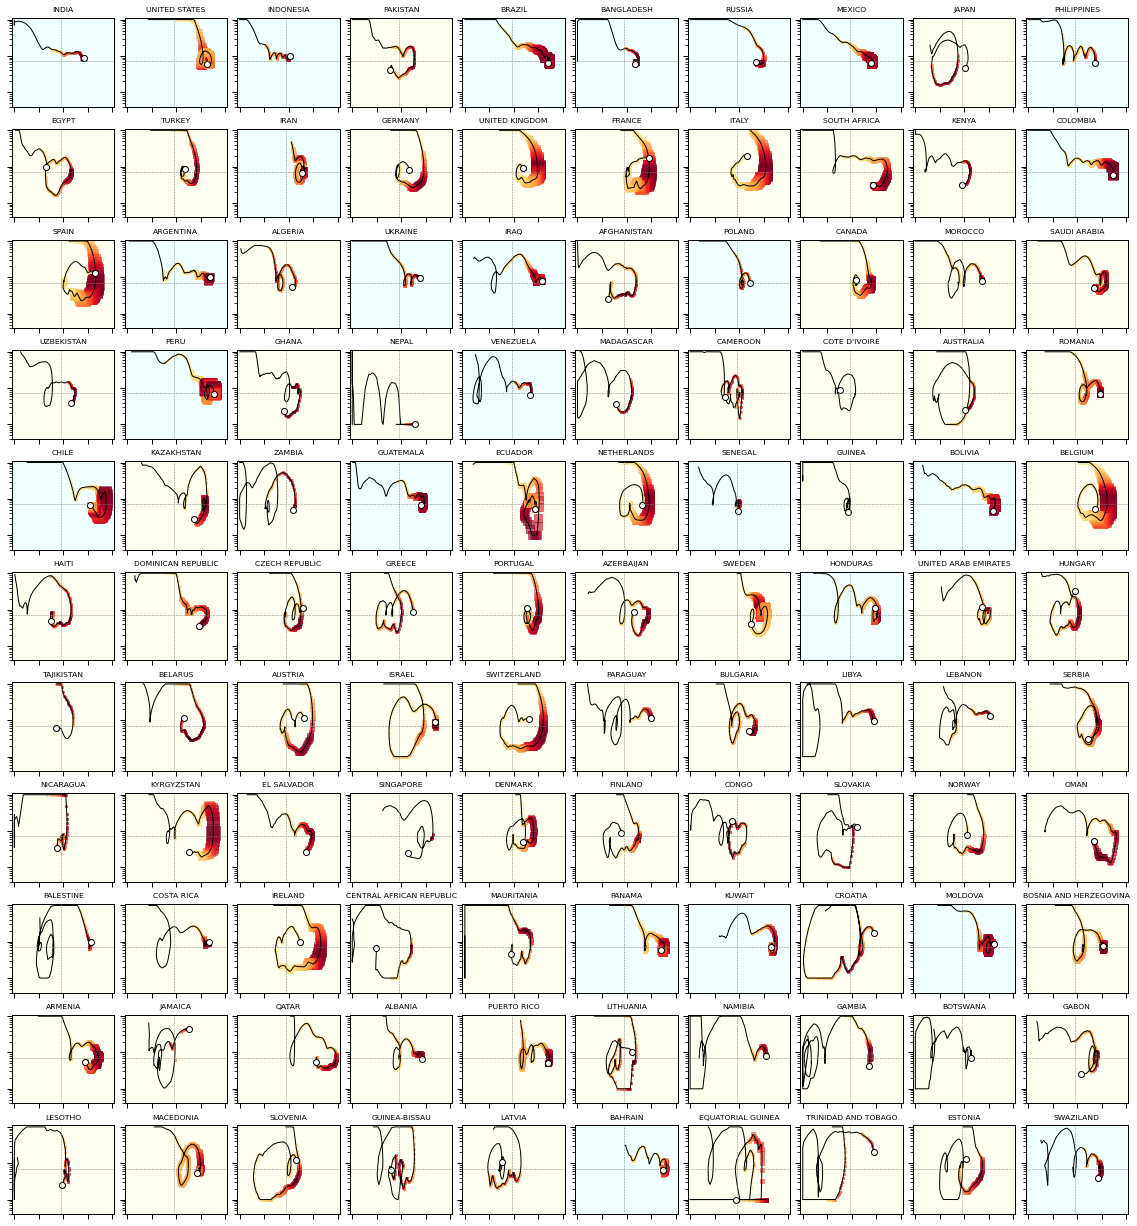

In [22]:
sns.set_context('paper', font_scale=.8)

ncols = 10

h, w = 2, 2


fig, axes = plot_covid_traces(data, nrows=((data.country.nunique()-1)//ncols)+1, ncols=ncols, h=h, w=w, size_scale=10, show_annotations=False, gridspec_kw=dict(hspace=0.25, wspace=0.1))

# Add outbreak types and colouring
for country, ax in zip(data['country'].unique(), axes.flatten()):
    ax.set_title(ax.get_title().replace('(', '[{}] (').format(
        data.set_index('country').loc[country].iloc[0]['outbreak_type']))
    
    ax.set_title(country.upper())
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    
    if data.set_index('country').loc[country].iloc[0]['outbreak_type']=='S':
        ax.set_facecolor('ivory')
    else:
        ax.set_facecolor('azure')




plt.tight_layout()